In [1]:
import basket_util
from basket_util import *

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
import collections

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import association_rules
from mlxtend.frequent_patterns import fpgrowth

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn import metrics

from datetime import date, datetime, timedelta
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve
import joblib

from pySankey.sankey import sankey

import plotly as py
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot, plot, init_notebook_mode, download_plotlyjs
init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)


/Users/yingli/opt/anaconda3/lib/python3.9/site-packages/xarray/core/pycompat.py:22: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  duck_array_version = LooseVersion(duck_array_module.__version__)
/Users/yingli/opt/anaconda3/lib/python3.9/site-packages/xarray/core/pycompat.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  duck_array_version = LooseVersion("0.0.0")
/Users/yingli/opt/anaconda3/lib/python3.9/site-packages/xarray/core/pycompat.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  duck_array_version = LooseVersion("0.0.0")
/Users/yingli/opt/anaconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/yingli/opt/anaconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: D

* use print(basket_util.__doc__) to get the doc string

In [2]:
#filename = 'new_baskets_adhie.csv'
filename = 'new_baskets_full.csv'
baskets = prep_data(filename, dropna = True, datecol = 'placed_at')

# remove outliers 
#baskets = baskets[baskets.merchant_id !=190]
#baskets = baskets[baskets.merchant_id !=12]
#baskets = baskets[baskets.merchant_id !=206]
#baskets = baskets[baskets.date >=  pd.to_datetime('2021-12-01').date()]
#baskets = baskets[baskets.date >=  pd.to_datetime('2021-09-27').date()]
#baskets = baskets[baskets.top_cat_id !=  27]



In [3]:
# read top level category name mapping
#cat_name = pd.read_csv("top_category_mapping_adhie.csv")
cat_name = pd.read_csv("top_category_mapping_full.csv")
cat_name_map= cat_name[["top_cat_id", "top_cat (EN)"]].set_index(keys="top_cat_id")
cat_name_map = cat_name_map.rename(columns= {"top_cat (EN)": "top_cat_name"})

import re
cat_name_map["top_cat_name"] = cat_name_map["top_cat_name"].apply(lambda x: re.sub("[\"\']", "",x))
cat_name_map["top_cat_name"] = cat_name_map["top_cat_name"].str.replace(" ", "_")

In [4]:
# join top category names
baskets.reset_index(drop = True)
baskets.set_index(keys="top_cat_id")
#baskets.head()
baskets = baskets.join(cat_name_map, on = "top_cat_id",how="left")

In [5]:
#get merchant attributes
merchant_attributes = get_merchant_attributes(baskets)

In [6]:
merchant_topcat = pd.pivot_table(
    baskets,
    index='merchant_id',   # Column to turn into new index
    columns='top_cat_name',  # Column to turn into new columns
    values=['order_id', 'qty', 'spent'], # Column to aggregate for values
    aggfunc={'order_id': 'nunique', 'qty':sum, 'spent':sum},  # Aggregation function
    fill_value= 0,
)
merchant_topcat.columns = [f'{x}_{y}' for x,y in merchant_topcat.columns]
merchant_topcat.columns = merchant_topcat.columns.str.replace("order_id", "num_orders")

In [7]:
df0 = (merchant_attributes
    .query('tenure_month <=1'))
df1 = (merchant_attributes
    .query('tenure_month > 1 and last_month <= 18')
) # churner
df2 = (merchant_attributes
    .query('tenure_month > 1 and last_month > 18')
) # non-churner
churn_label = pd.concat([pd.DataFrame(zip(df0['merchant_id'], [1] * len(df0)), columns = ['merchant_id', 'churn']),
        pd.DataFrame(zip(df1['merchant_id'], [1] * len(df1)), columns = ['merchant_id', 'churn']),
        pd.DataFrame(zip(df2['merchant_id'], [0] * len(df2)), columns = ['merchant_id', 'churn'])], axis=0)
churn_label = churn_label.set_index(keys='merchant_id')
#df0.merchant_id.nunique() , df1.merchant_id.nunique(), df2.merchant_id.nunique(), df0.merchant_id.nunique() + df1.merchant_id.nunique()+ df2.merchant_id.nunique()

In [8]:
merchant_attributes = merchant_attributes.set_index(keys='merchant_id')

wide = True
if wide:
    merchant_attributes = pd.merge(merchant_attributes, merchant_topcat, on="merchant_id")
df_churn = pd.merge(churn_label, merchant_attributes, on = "merchant_id")
X_train, X_test, y_train, y_test = train_test_split(
    merchant_attributes, churn_label, test_size=0.33, random_state=7)

In [9]:

clf = DecisionTreeClassifier(criterion= "entropy", random_state=0,max_depth=5)
clf = clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
cv_score = cross_val_score(clf, X_train, y_train, cv=10)

In [ ]:
clf.predict(X_test)

In [11]:
from sklearn import tree
tree.export_text(clf)

'|--- feature_2 <= 13.50\n|   |--- class: 1\n|--- feature_2 >  13.50\n|   |--- feature_2 <= 14.50\n|   |   |--- feature_7 <= 12.50\n|   |   |   |--- feature_10 <= 930375.00\n|   |   |   |   |--- feature_10 <= 506062.50\n|   |   |   |   |   |--- class: 1\n|   |   |   |   |--- feature_10 >  506062.50\n|   |   |   |   |   |--- class: 0\n|   |   |   |--- feature_10 >  930375.00\n|   |   |   |   |--- feature_72 <= 2.50\n|   |   |   |   |   |--- class: 1\n|   |   |   |   |--- feature_72 >  2.50\n|   |   |   |   |   |--- class: 0\n|   |   |--- feature_7 >  12.50\n|   |   |   |--- feature_106 <= 607250.00\n|   |   |   |   |--- feature_9 <= 6.50\n|   |   |   |   |   |--- class: 1\n|   |   |   |   |--- feature_9 >  6.50\n|   |   |   |   |   |--- class: 0\n|   |   |   |--- feature_106 >  607250.00\n|   |   |   |   |--- feature_49 <= 1.50\n|   |   |   |   |   |--- class: 0\n|   |   |   |   |--- feature_49 >  1.50\n|   |   |   |   |   |--- class: 1\n|   |--- feature_2 >  14.50\n|   |   |--- feature

In [12]:
list(merchant_attributes.columns)

['total_spent',
 'num_orders',
 'first_month',
 'last_month',
 'num_months',
 'num_weeks',
 'num_days',
 'num_skus',
 'num_top_cats',
 'num_sub_cats',
 'avg_spent_per_order',
 'tenure_month',
 'num_orders_baby_care',
 'num_orders_baby_food',
 'num_orders_bath_soap',
 'num_orders_body_care',
 'num_orders_bottled_water',
 'num_orders_breakfast_food',
 'num_orders_canned_food',
 'num_orders_carpentry_tools',
 'num_orders_cigarette',
 'num_orders_dental_care',
 'num_orders_dish_soap',
 'num_orders_external_medicine',
 'num_orders_floor_cleaning_soap',
 'num_orders_food_material',
 'num_orders_gas_lighter',
 'num_orders_general_medicine',
 'num_orders_hair_care',
 'num_orders_household_general_supplies',
 'num_orders_household_hygiene_supplies',
 'num_orders_ingredients',
 'num_orders_instant_food',
 'num_orders_laundry_soap',
 'num_orders_medical_supplies',
 'num_orders_packaged_drinks',
 'num_orders_packaged_tea',
 'num_orders_powder_drink',
 'num_orders_protein_food',
 'num_orders_sachet

In [13]:
text_representation = tree.export_text(clf,feature_names=list(merchant_attributes.columns))
print(text_representation)

|--- first_month <= 13.50
|   |--- class: 1
|--- first_month >  13.50
|   |--- first_month <= 14.50
|   |   |--- num_skus <= 12.50
|   |   |   |--- avg_spent_per_order <= 930375.00
|   |   |   |   |--- avg_spent_per_order <= 506062.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- avg_spent_per_order >  506062.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- avg_spent_per_order >  930375.00
|   |   |   |   |--- qty_sachet_drink <= 2.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- qty_sachet_drink >  2.50
|   |   |   |   |   |--- class: 0
|   |   |--- num_skus >  12.50
|   |   |   |--- spent_snack <= 607250.00
|   |   |   |   |--- num_sub_cats <= 6.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- num_sub_cats >  6.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- spent_snack >  607250.00
|   |   |   |   |--- qty_bottled_water <= 1.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- qty_bottled_water >  1.50
|   |   |   |   |   |--- class: 1
|   

In [14]:
from sklearn.tree import _tree

def get_rules(tree, feature_names, class_names):
    """ 
    credit: from https://mljar.com/blog/extract-rules-decision-tree/ 
    """
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if "
        
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += " then "
        if class_names is None:
            rule += "response: "+str(np.round(path[-1][0][0][0],3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),2)}%)"
        rule += f" | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules

In [15]:
rules = get_rules(clf, feature_names=list(merchant_attributes.columns), class_names=np.array(["non-churn", "churn"]))
for r in rules:
    print(r)

if (first_month <= 13.5) then class: churn (proba: 100.0%) | based on 1,092 samples
if (first_month > 13.5) and (first_month > 14.5) and (spent_sachet_drink <= 132250.0) and (num_orders_snack <= 2.5) and (total_spent <= 40087750.0) then class: non-churn (proba: 94.85%) | based on 97 samples
if (first_month > 13.5) and (first_month > 14.5) and (spent_sachet_drink > 132250.0) and (total_spent > 2307750.0) then class: non-churn (proba: 100.0%) | based on 71 samples
if (first_month > 13.5) and (first_month <= 14.5) and (num_skus <= 12.5) and (avg_spent_per_order > 930375.0) and (qty_sachet_drink <= 2.5) then class: churn (proba: 68.75%) | based on 48 samples
if (first_month > 13.5) and (first_month <= 14.5) and (num_skus > 12.5) and (spent_snack > 607250.0) and (qty_bottled_water > 1.5) then class: churn (proba: 59.38%) | based on 32 samples
if (first_month > 13.5) and (first_month <= 14.5) and (num_skus > 12.5) and (spent_snack <= 607250.0) and (num_sub_cats > 6.5) then class: non-churn (

In [16]:
score,cv_score

(0.9348441926345609,
 array([0.94444444, 0.88194444, 0.91608392, 0.93706294, 0.92307692,
        0.93006993, 0.90909091, 0.95104895, 0.93706294, 0.96503497]))

In [17]:
churn_label.churn.value_counts()


1    1760
0     378
Name: churn, dtype: int64

In [18]:
y_train.value_counts(), y_test.value_counts()

(churn
 1        1169
 0         263
 dtype: int64,
 churn
 1        591
 0        115
 dtype: int64)

In [19]:
1168/(1169+263), 591/(591+115)

(0.8156424581005587, 0.8371104815864022)

[Text(0.5086206896551724, 0.9166666666666666, 'X[2] <= 13.5\nentropy = 0.688\nsamples = 1432\nvalue = [263, 1169]'),
 Text(0.47413793103448276, 0.75, 'entropy = 0.0\nsamples = 1092\nvalue = [0, 1092]'),
 Text(0.5431034482758621, 0.75, 'X[2] <= 14.5\nentropy = 0.772\nsamples = 340\nvalue = [263, 77]'),
 Text(0.27586206896551724, 0.5833333333333334, 'X[7] <= 12.5\nentropy = 0.977\nsamples = 156\nvalue = [92, 64]'),
 Text(0.13793103448275862, 0.4166666666666667, 'X[10] <= 930375.0\nentropy = 0.993\nsamples = 73\nvalue = [33, 40]'),
 Text(0.06896551724137931, 0.25, 'X[10] <= 506062.5\nentropy = 0.902\nsamples = 22\nvalue = [15, 7]'),
 Text(0.034482758620689655, 0.08333333333333333, 'entropy = 0.971\nsamples = 10\nvalue = [4, 6]'),
 Text(0.10344827586206896, 0.08333333333333333, 'entropy = 0.414\nsamples = 12\nvalue = [11, 1]'),
 Text(0.20689655172413793, 0.25, 'X[72] <= 2.5\nentropy = 0.937\nsamples = 51\nvalue = [18, 33]'),
 Text(0.1724137931034483, 0.08333333333333333, 'entropy = 0.896\n

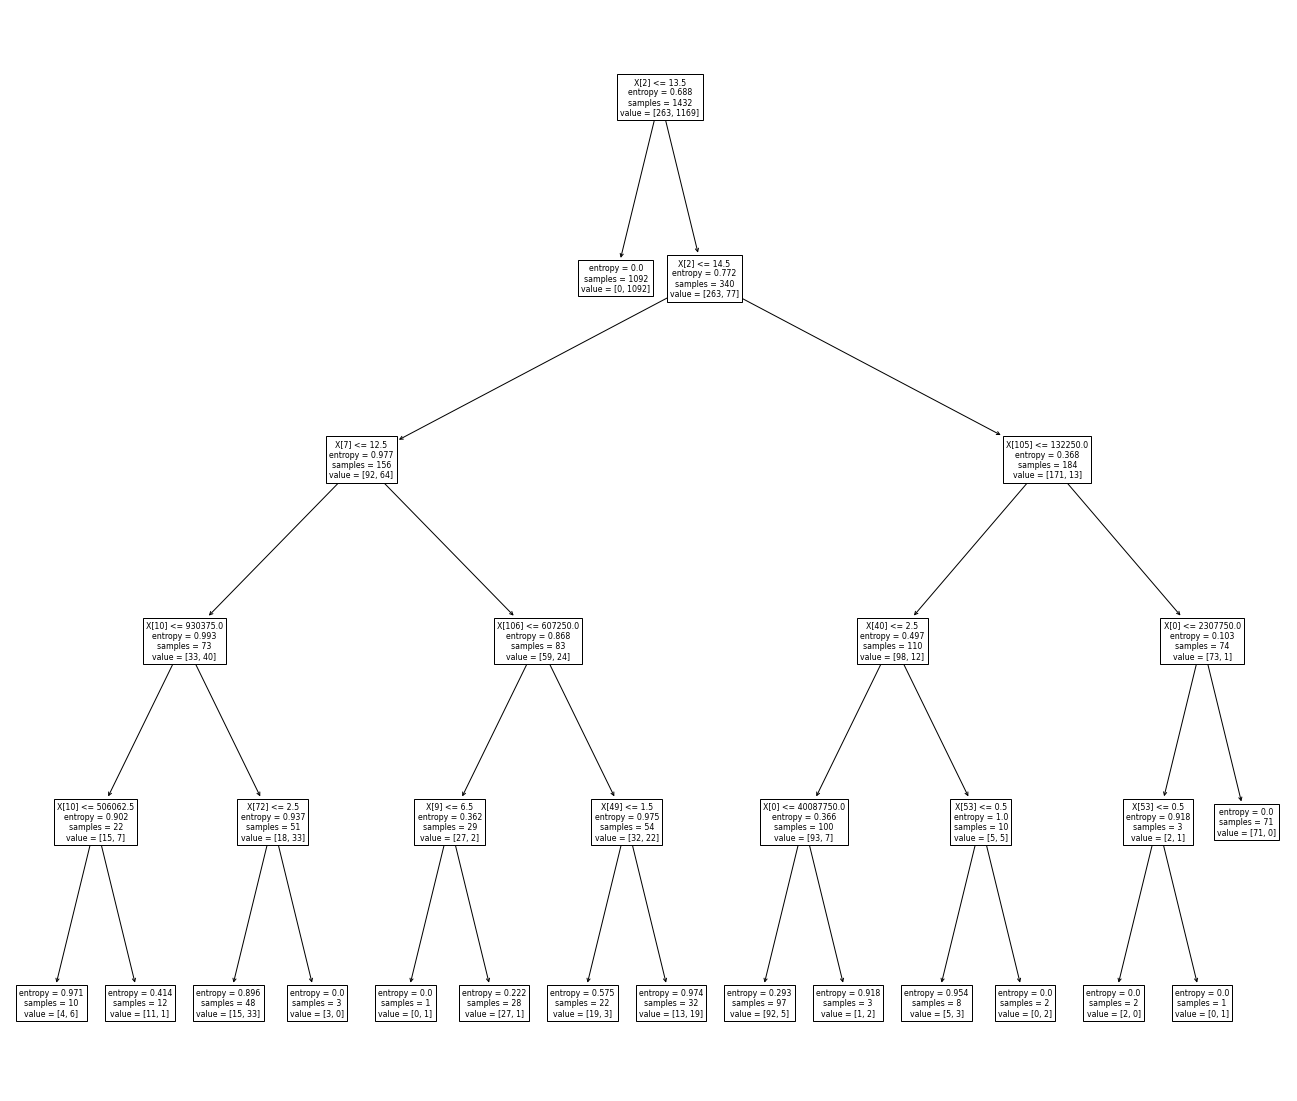

In [20]:
plt.figure(figsize=(23, 20))  
tree.plot_tree(clf)

In [21]:
X_train.columns[[2,7,105,40,0,106,10,72,9,49,53]]

Index(['first_month', 'num_skus', 'spent_sachet_drink', 'num_orders_snack',
       'total_spent', 'spent_snack', 'avg_spent_per_order', 'qty_sachet_drink',
       'num_sub_cats', 'qty_bottled_water', 'qty_cigarette'],
      dtype='object')

In [22]:
merchant_attributes.columns[[2,7,78,32,95,48,100]]

Index(['first_month', 'num_skus', 'spent_baby_care', 'num_orders_instant_food',
       'spent_household_general_supplies', 'qty_body_care',
       'spent_medical_supplies'],
      dtype='object')

In [23]:
tn,fp,fn,tp  = metrics.confusion_matrix(y_test, clf.predict(X_test)).ravel()/(len(y_test))
tn,fp,fn,tp 

(0.1388101983002833,
 0.024079320113314446,
 0.04107648725212465,
 0.7960339943342776)

In [24]:
y_score = clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_score, pos_label = 2)
fpr, tpr, thresholds

(array([0.        , 0.7733711 , 0.79745042, 0.80028329, 0.80594901,
        0.82011331, 0.82719547, 0.8427762 , 0.85552408, 0.92492918,
        0.94759207, 1.        ]),
 array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]),
 array([2.        , 1.        , 0.6875    , 0.66666667, 0.6       ,
        0.59375   , 0.375     , 0.13636364, 0.08333333, 0.05154639,
        0.03571429, 0.        ]))

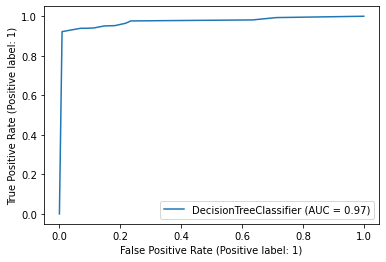

In [25]:
metrics.plot_roc_curve(clf, X_test, y_test)

In [ ]:
for i,(j,k) in enumerate(clf.predict_proba(X_test)):
    print(j)

### Feature Seletion

In [26]:
from sklearn.feature_selection import RFE
select = RFE(RandomForestClassifier(random_state=1, bootstrap = True, criterion = 'entropy',
                                   max_depth = 7, max_features = 'auto', min_samples_leaf = 1,
                                   min_samples_split = 5, n_estimators = 100), n_features_to_select = 20)
select.fit(X_train, y_train)

RFE(estimator=RandomForestClassifier(criterion='entropy', max_depth=7,
                                     max_features='auto', min_samples_split=5,
                                     random_state=1),
    n_features_to_select=20)

In [27]:
select.feature_names_in_

array(['total_spent', 'num_orders', 'first_month', 'last_month',
       'num_months', 'num_weeks', 'num_days', 'num_skus', 'num_top_cats',
       'num_sub_cats', 'avg_spent_per_order', 'tenure_month',
       'num_orders_baby_care', 'num_orders_baby_food',
       'num_orders_bath_soap', 'num_orders_body_care',
       'num_orders_bottled_water', 'num_orders_breakfast_food',
       'num_orders_canned_food', 'num_orders_carpentry_tools',
       'num_orders_cigarette', 'num_orders_dental_care',
       'num_orders_dish_soap', 'num_orders_external_medicine',
       'num_orders_floor_cleaning_soap', 'num_orders_food_material',
       'num_orders_gas_lighter', 'num_orders_general_medicine',
       'num_orders_hair_care', 'num_orders_household_general_supplies',
       'num_orders_household_hygiene_supplies', 'num_orders_ingredients',
       'num_orders_instant_food', 'num_orders_laundry_soap',
       'num_orders_medical_supplies', 'num_orders_packaged_drinks',
       'num_orders_packaged_tea', 

In [28]:
from operator import itemgetter

def RFE_get_ranks(RFE_model):
    features = X_train.columns.to_list()
    rank = []
    feature = []
    for x, y in (sorted(zip(RFE_model.ranking_, features), key=itemgetter(0))):
        rank.append(x)
        feature.append(y)
    rfe_feature_rank = pd.DataFrame({'rank':rank, 'feature':feature})
    return rfe_feature_rank

In [41]:
RFE_feature_ranks = RFE_get_ranks(select)
RFE_feature_ranks[RFE_feature_ranks["rank"]==1].sort_values(by="feature")

,rank,feature
9,1,avg_spent_per_order
2,1,first_month
3,1,last_month
6,1,num_days
4,1,num_months
1,1,num_orders
11,1,num_orders_food_material
12,1,num_orders_ingredients
7,1,num_skus
8,1,num_sub_cats


In [40]:
from operator import index


rf_df = pd.DataFrame(select.ranking_, index=X_train.columns,columns=["Rank"]).sort_values(by="Rank",ascending=True)
pd.DataFrame.sort_index(rf_df[rf_df["Rank"]==1])


,Rank
avg_spent_per_order,1
first_month,1
last_month,1
num_days,1
num_months,1
num_orders,1
num_orders_food_material,1
num_orders_ingredients,1
num_skus,1
num_sub_cats,1


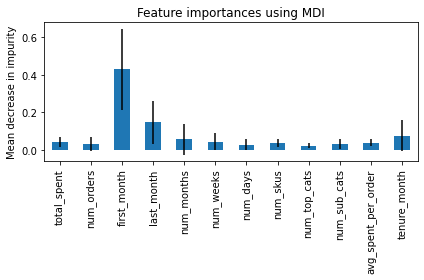

In [39]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)
importances = forest.feature_importances_
forest_importances = pd.Series(importances, index=merchant_attributes.columns.to_list())
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [40]:
forest_importances.sort_values(ascending=False)

first_month            0.428686
last_month             0.148754
tenure_month           0.076677
num_months             0.057031
num_weeks              0.044751
total_spent            0.043949
avg_spent_per_order    0.040395
num_skus               0.039609
num_sub_cats           0.034067
num_orders             0.032138
num_days               0.030142
num_top_cats           0.023800
dtype: float64

### now df_churn is ready to be used for training a supervised learning model

In [ ]:
for s in merchant_attributes.columns:
    print(s)

In [41]:
np.random.seed(0)
merchant_attributes.reset_index(drop=True)
churn_label.reset_index(drop=True)
indices = np.random.permutation(len(merchant_attributes))
np.random.seed(0)
merchant_attributes.reset_index(drop=True)
churn_label.reset_index(drop=True)
indices = np.random.permutation(len(merchant_attributes))
df_churn_x_train = merchant_attributes.iloc[indices[:-10]]
df_churn_y_train = churn_label.iloc[indices[:-10]]
df_churn_x_test = merchant_attributes.iloc[indices[-10:]]
df_churn_y_test = churn_label.iloc[indices[-10:]]
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(p=1)
knn.fit(df_churn_x_train, df_churn_y_train)

KNeighborsClassifier(p=1)

In [42]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(p=1)
knn.fit(X_train, y_train)
confusion_matrix(y_test, knn.predict(X_test))


array([[ 25,  90],
       [ 35, 556]])

In [43]:
score = knn.score(X_test, y_test)
cv_score = cross_val_score(knn, X_train, y_train, cv=10)
score, cv_score

(0.8229461756373938,
 array([0.79166667, 0.80555556, 0.8041958 , 0.76223776, 0.74825175,
        0.79020979, 0.77622378, 0.81118881, 0.81118881, 0.82517483]))

In [44]:
print(classification_report(knn.predict(X_test),y_test))

              precision    recall  f1-score   support

           0       0.22      0.42      0.29        60
           1       0.94      0.86      0.90       646

    accuracy                           0.82       706
   macro avg       0.58      0.64      0.59       706
weighted avg       0.88      0.82      0.85       706



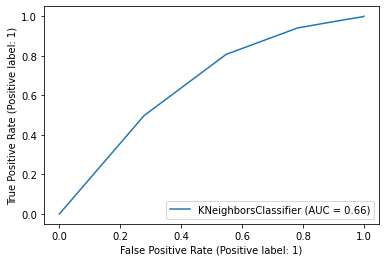

In [45]:
metrics.plot_roc_curve(knn, X_test, y_test)

In [46]:
print(knn.predict_proba(X_test))

[[0.  1. ]
 [0.4 0.6]
 [0.2 0.8]
 ...
 [0.2 0.8]
 [0.4 0.6]
 [0.  1. ]]


In [47]:
knn.predict(X_test),y_test

(array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 

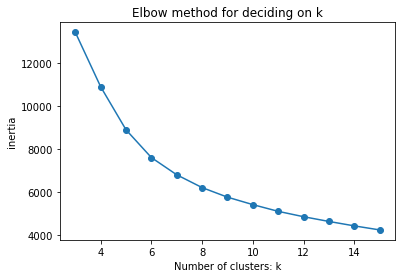

In [48]:
# for jaya
#baskets = baskets[baskets.merchant_id !=464]

colnames = merchant_attributes.columns
clusters_range = [3,4,5,6,7,8,9,10,11,12,13,14,15]
find_elbow(merchant_attributes, colnames,clusters_range)

In [49]:
colnames = merchant_attributes.columns
k = 6
merchant_kmeans = run_kmeans(merchant_attributes, colnames,k)
merchant_kmeans.groupby("cluster").size()

cluster
0    535
1    176
2     16
3    619
4      1
5    791
dtype: int64

In [50]:
(merchant_kmeans.query('cluster ==4'))

,total_spent,num_orders,first_month,last_month,num_months,num_weeks,num_days,num_skus,num_top_cats,num_sub_cats,avg_spent_per_order,tenure_month,cluster
merchant_id,,,,,,,,,,,,,
664,3.947079e+09,3918,9,15,7,23,110,598,27,70,1.007422e+06,7,4


In [53]:
sku_attributes = get_sku_attributes(baskets)
order_attributes = get_order_attributes(baskets)

sku_by_day = get_skus_by_day(baskets)
top_cats = make_top_cats(baskets)

In [54]:
merchant_attributes = merchant_attributes.reset_index()

In [55]:
fig = px.parallel_coordinates(sku_attributes[["first_month","sku_id","last_month","tenure_month"]], \
        color="tenure_month", labels={"sku_id": "SKU ID",
                "first_month": "First Month", "last_month": "Last Month", },)
                             #color_continuous_scale=px.colors.diverging.Tealrose,
                            # color_continuous_midpoint=2)
fig.show()

In [56]:
fig = px.parallel_coordinates(merchant_attributes[["first_month","merchant_id","last_month","tenure_month"]], \
        color="tenure_month", labels={"merchant_id": "merchant ID",
                "first_month": "First Month", "last_month": "Last Month", },)
                             #color_continuous_scale=px.colors.diverging.Tealrose,
                            # color_continuous_midpoint=2)
fig.show()

In [90]:
baskets = baskets[baskets.merchant_id !=190]
baskets = baskets[baskets.merchant_id !=12]
baskets = baskets[baskets.merchant_id !=206]
baskets = baskets[baskets.date >=  pd.to_datetime('2021-09-27').date()]

df1 = pd.pivot_table(
    baskets,
    index='merchant_id',   # Column to turn into new index
    columns='top_cat_id',  # Column to turn into new columns
    values='order_id', # Column to aggregate for values
    aggfunc="nunique")    # Aggregation function
df2 = pd.pivot_table(
    baskets,
    index='merchant_id',   # Column to turn into new index
    columns='top_cat_id',  # Column to turn into new columns
    values='spent', # Column to aggregate for values
    aggfunc="sum")    # Aggregation function
df1.fillna(0,inplace=True)
df2.fillna(0,inplace=True)

In [65]:
from math import log2
x = 0.8
probs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
info = [-log2(p) for p in probs]
gini = [ 1 - p*p - (1-p)*(1-p) for p in probs]

#px.line(probs, info)
px.scatter(probs,gini)


In [91]:
df1.head()

top_cat_id,1,2,3,4,5,6,7,8,9,10,...,26,27,28,29,30,31,32,33,34,35
merchant_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,1.0,8.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,2.0,7.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,11.0,0.0,0.0,1.0,1.0,9.0,...,3.0,29.0,0.0,3.0,0.0,1.0,1.0,1.0,4.0,6.0
4,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [94]:
import scipy.cluster.hierarchy as shc
from sklearn.preprocessing import normalize
data_scaled = normalize(df1)
data_scaled

array([[0.        , 0.        , 0.        , ..., 0.        , 0.07955573,
        0.        ],
       [0.09166985, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.02490677, ..., 0.02490677, 0.0996271 ,
        0.14944064],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.10050378,
        0.10050378],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

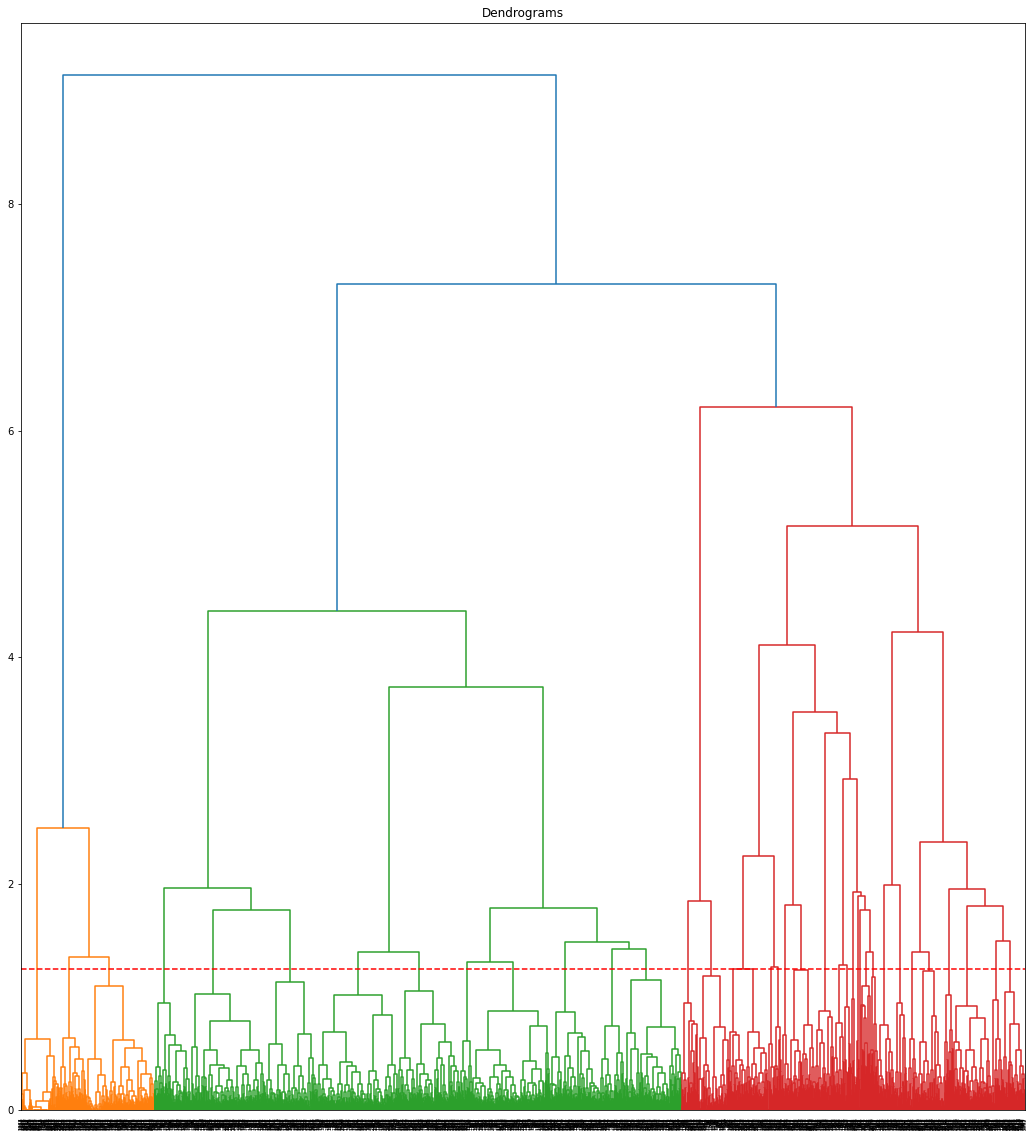

In [41]:
import scipy.cluster.hierarchy as shc
from sklearn.preprocessing import normalize
data_scaled = normalize(merchant_attributes)
data_scaled = pd.DataFrame(data_scaled, columns=merchant_attributes.columns)
#data_scaled.head()

plt.figure(figsize=(18, 20))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(data_scaled, method='ward'))
plt.axhline(y=1.25, color='r', linestyle='--')


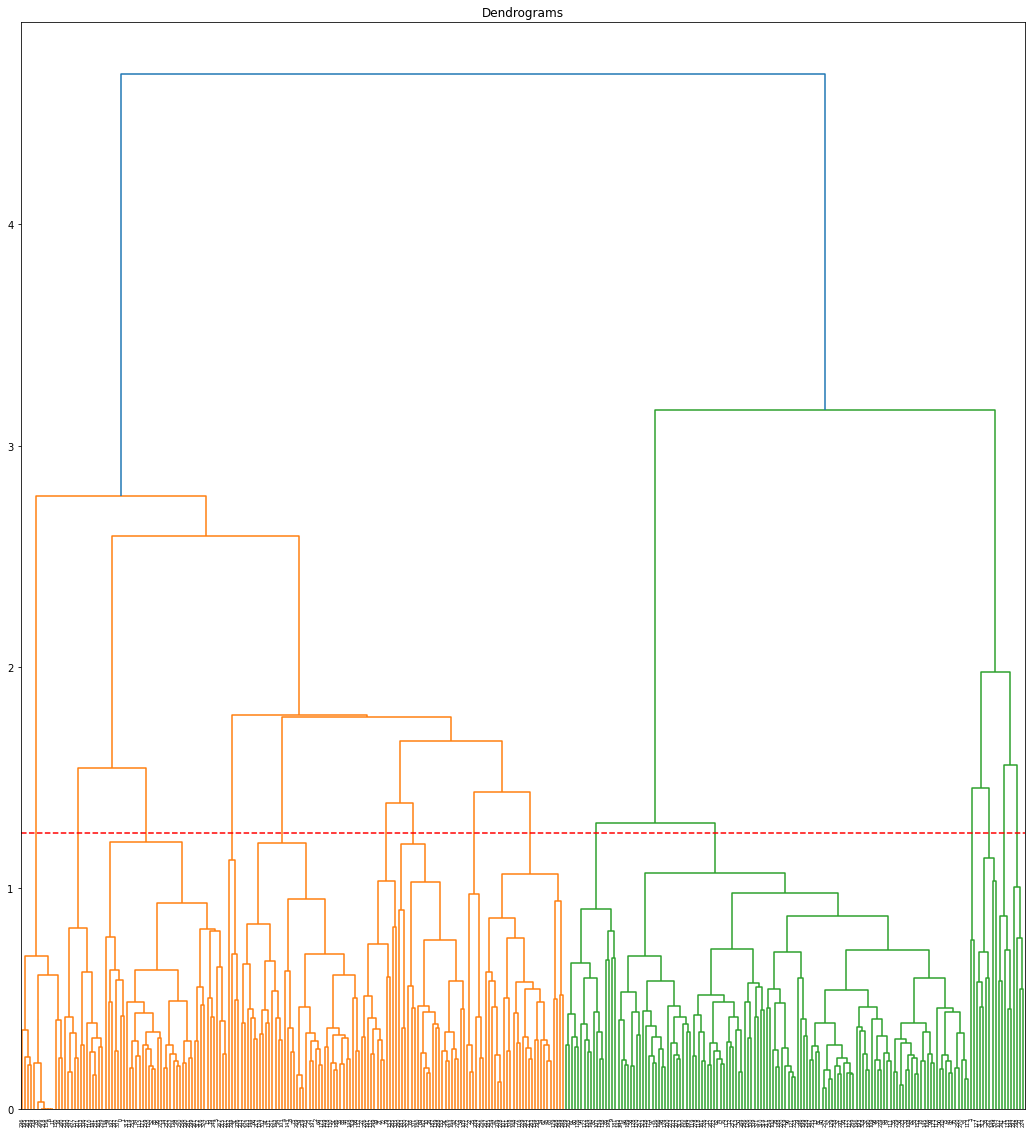

In [74]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(18, 20))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(data_scaled, method='ward'))
plt.axhline(y=1.25, color='r', linestyle='--')


In [89]:
data_scaled.head()

,merchant_id,total_spent,num_orders,first_month,last_month,num_months,num_weeks,num_days,num_skus,num_top_cats,num_sub_cats,avg_spent_per_order,tenure_month
0,7.880304e-08,0.999635,9.719042e-07,2.889445e-07,4.202829e-07,1.576061e-07,3.414798e-07,6.829597e-07,3.808814e-06,6.304243e-07,1.129510e-06,0.027017,1.576061e-07
1,1.663741e-06,0.894427,6.654964e-07,4.325727e-06,5.989468e-06,6.654964e-07,6.654964e-07,6.654964e-07,6.654964e-06,2.329237e-06,2.994734e-06,0.447214,1.996489e-06
2,4.595998e-06,0.894427,9.191996e-07,2.757599e-06,4.595998e-06,9.191996e-07,9.191996e-07,9.191996e-07,1.746479e-05,5.515198e-06,9.191996e-06,0.447214,2.297999e-06
3,3.095840e-09,1.000000,9.107397e-07,1.688640e-09,5.628799e-09,1.970080e-09,5.910239e-09,3.292848e-08,1.865947e-07,9.287519e-09,2.279664e-08,0.000309,4.221599e-09
4,1.860584e-06,0.948683,4.293656e-07,8.587312e-07,1.431219e-06,2.862437e-07,2.862437e-07,2.862437e-07,1.288097e-06,1.431219e-07,1.431219e-07,0.316228,7.156093e-07


 - big cluster (131 members) was only able to be broken down at n-cluster = 15
 - cluster number = 5 or 8 are the best at breaking down big clusters.

In [95]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=8, affinity='euclidean', linkage='ward')  
df1_results['label'] = pd.DataFrame(cluster.fit_predict(data_scaled))
df1_results.groupby('label').count()

,0
label,
0,66
1,9
2,9
3,39
4,53
5,131
6,4
7,14
